In [1]:
#! pip install pyvis
#from pyvis.network import Network

In [8]:
import json
import os
import pandas as pd
import networkx as nx
import gremlin_python
from langchain_text_splitters import RecursiveCharacterTextSplitter
import matplotlib.pyplot as plt
import pickle

In [2]:
# Path to corpus file
multihop_corpus_path = os.path.join("..", "data", "Multi-hop_RAG_dataset", "corpus.json")

# Read JSON
with open(multihop_corpus_path, "r", encoding="utf-8") as f:
    corpus = json.load(f)

# Convert corpus data into df
corpus_as_df = pd.DataFrame(corpus)

In [3]:
# Add new feature to act as a unique identifier for each article
corpus_as_df["article_id"] = corpus_as_df.index.copy()

corpus_as_df["author"] = corpus_as_df["author"].fillna("unknown")

corpus_as_df.head()

,title,author,source,published_at,category,url,body,article_id
0,200+ of the best deals from Amazon's Cyber Mon...,unknown,Mashable,2023-11-27T08:45:59+00:00,entertainment,https://mashable.com/article/cyber-monday-deal...,"Table of Contents Table of Contents Echo, Fire...",0
1,ASX set to drop as Wall Street’s September slu...,Stan Choe,The Sydney Morning Herald,2023-09-26T19:11:30+00:00,business,https://www.smh.com.au/business/markets/asx-se...,"ETF provider Betashares, which manages $30 bil...",1
2,Amazon sellers sound off on the FTC's 'long-ov...,unknown,Cnbc | World Business News Leader,2023-10-06T21:31:00+00:00,business,https://www.cnbc.com/2023/10/06/amazon-sellers...,A worker sorts out parcels in the outbound doc...,2
3,"Christmas Day preview: 49ers, Ravens square of...","Colum Dell, Yardbarker",Yardbarker,2023-12-24T23:34:39+00:00,sports,https://www.yardbarker.com/nfl/articles/christ...,"Christmas Day isn't just for the NBA, as the N...",3
4,"Raiders vs. Lions live score, updates, highlig...",Dan Treacy,Sporting News,2023-10-30T22:20:03+00:00,sports,https://www.sportingnews.com/us/nfl/news/raide...,The Lions just needed to get themselves back i...,4


In [4]:
# create graph
G = nx.DiGraph()

# Define sets to store unique authors, sources, and categories and avoid duplicates
authors = set()
sources = set()
categories = set()

# Iterate over rows in corpus and add nodes and edges to graph
for i, row in corpus_as_df.iterrows():
    #if i == 10:
        #break

    #print(row)
    #print("processing row ", i)

    # Extract data from row
    article_id = row["article_id"]

    # Add article node
    G.add_node(article_id, title=row["title"], type="article")

    # If author is not in set, add author node and edges
    author_id = row["author"]
    if author_id not in authors:
        authors.add(author_id)
        G.add_node(author_id, type="author")

    G.add_edge(article_id, author_id, relation="WRITTEN_BY")  # (Ar -> Au)
    G.add_edge(author_id, article_id, relation="AUTHORED")    # (Au -> Ar)

    # If author is not in set, add author node and edges
    source_id = row["source"]
    if source_id not in sources:
        sources.add(source_id)
        G.add_node(source_id, type="source")

    G.add_edge(article_id, source_id, relation="PUBLISHED_IN")  # (Ar -> So)
    G.add_edge(source_id, article_id, relation="PUBLISHES")     # (So -> Ar)

    # If author is not in set, add author node and edges
    category_id = row["category"]
    if category_id not in categories:
        categories.add(author_id)
        G.add_node(category_id, type="category")

    G.add_edge(article_id, category_id, relation="CLASSIFIED_WITHIN")  # (Ar -> Ca)
    G.add_edge(category_id, article_id, relation="COVERED_IN")         # (Ca -> Ar)

In [5]:
# Define chunk size (n words) and overlap size (s words)
n = 5000  # Number of words per chunk
s = 200   # Overlap size

# Iterate through each article node in the graph
for article_id in range(len(corpus_as_df)):  # Assuming article IDs are sequential from 0 to 608
    # Retrieve the article text from the DataFrame
    article_text = corpus_as_df.loc[article_id, "body"]

    if pd.isna(article_text) or not isinstance(article_text, str):
        continue  # Skip articles with missing or non-string text

    # Use LangChain's RecursiveCharacterTextSplitter for chunking
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=n, chunk_overlap=s)
    chunks = text_splitter.split_text(article_text)

    # Add each chunk as a new node and connect it to the article
    chunk_nodes = []
    
    for i, chunk_text in enumerate(chunks):
        chunk_id = f"{article_id}_chunk_{i}"  # Unique chunk ID

        # Add chunk node
        G.add_node(chunk_id, type="chunk", text=chunk_text)

        # Connect chunk to article with bidirectional edges
        G.add_edge(article_id, chunk_id, relation="CONTAINS")
        G.add_edge(chunk_id, article_id, relation="BELONGS_TO")

        # Store chunk nodes for sequential linking
        chunk_nodes.append(chunk_id)

    # Create bidirectional links between sequential chunks
    for i in range(len(chunk_nodes) - 1):
        G.add_edge(chunk_nodes[i], chunk_nodes[i + 1], relation="NEXT_CHUNK")
        G.add_edge(chunk_nodes[i + 1], chunk_nodes[i], relation="PREVIOUS_CHUNK")


In [9]:
with open("../data/graph.pkl", "wb") as f:
    pickle.dump(G, f)

In [6]:
def visualize_node_neighbors(G, node_id):
    """
    Visualizes the neighborhood of a given node in a NetworkX graph.

    This function extracts a subgraph containing the specified node and all its directly 
    connected neighbors, then visualizes it using Matplotlib. The selected node is highlighted 
    in red, while its neighbors are displayed in light blue. If the graph is directed, 
    arrows indicate edge direction.

    Parameters:
    -----------
    G : networkx.Graph or networkx.DiGraph
        The input graph where the node and its neighbors exist.
    node_id : str or int
        The identifier of the node whose neighborhood is to be visualized.

    Returns:
    --------
    None
        Displays a Matplotlib plot of the subgraph.
    """
    if node_id not in G:
        print(f"Node '{node_id}' not found in the graph.")
        return
    
    # Create a subgraph with the node and its neighbors
    neighbors = list(G.neighbors(node_id))  # Get all connected nodes
    subgraph_nodes = [node_id] + neighbors  # Include the target node
    subgraph = G.subgraph(subgraph_nodes)   # Create subgraph

    # Draw the subgraph
    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(subgraph, seed=42)  # Layout for better visualization
    nx.draw(subgraph, pos, with_labels=True, node_size=800, node_color="lightblue", edge_color="gray", font_size=8)
    nx.draw_networkx_edges(subgraph, pos, arrowstyle="->", arrowsize=15)

    # Highlight the selected node in red
    nx.draw_networkx_nodes(subgraph, pos, nodelist=[node_id], node_color="red", node_size=1000)

    plt.title(f"Neighborhood of Node: {node_id}")
    plt.show()

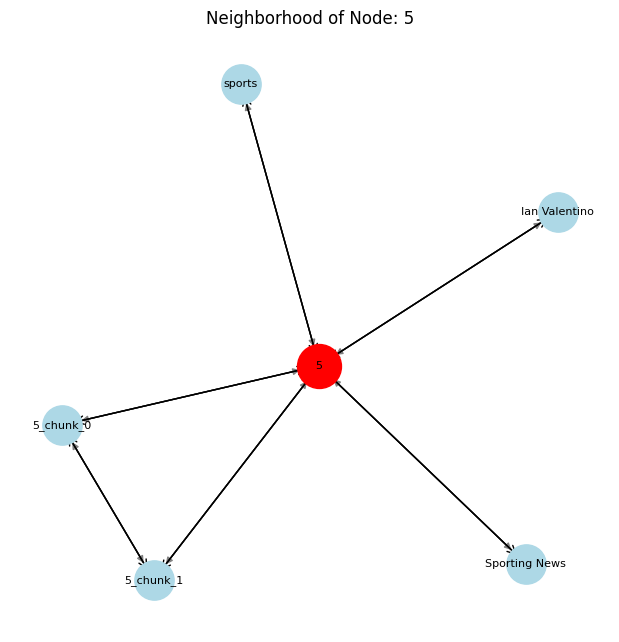

In [7]:
# Example usage
visualize_node_neighbors(G, 5) 

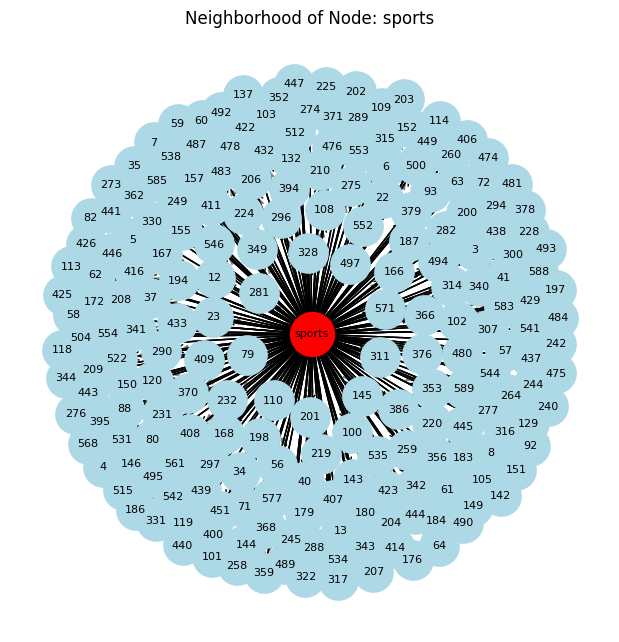

In [ ]:
# Example usage
visualize_node_neighbors(G, "sports") 

In [9]:
def get_chunk_text(G, chunk_id):
    """
    Retrieves the text content of a specified chunk node in the graph.

    Parameters:
    -----------
    G : networkx.Graph or networkx.DiGraph
        The input graph where the chunk nodes exist.
    chunk_id : str or int
        The identifier of the chunk whose text content is to be retrieved.

    Returns:
    --------
    str
        The text content of the specified chunk, or a message if the chunk is not found.
    """
    if chunk_id not in G:
        return f"Chunk '{chunk_id}' not found in the graph."

    # Retrieve the chunk's text from its attributes
    chunk_text = G.nodes[chunk_id].get("text", "No text available")

    return chunk_text

In [18]:
# Example usage
chunk_id = "5_chunk_0"  # Replace with the actual chunk ID you want to inspect
#print(get_chunk_text(G, chunk_id))

In [19]:
#print(corpus_as_df.iloc[5]["body"])

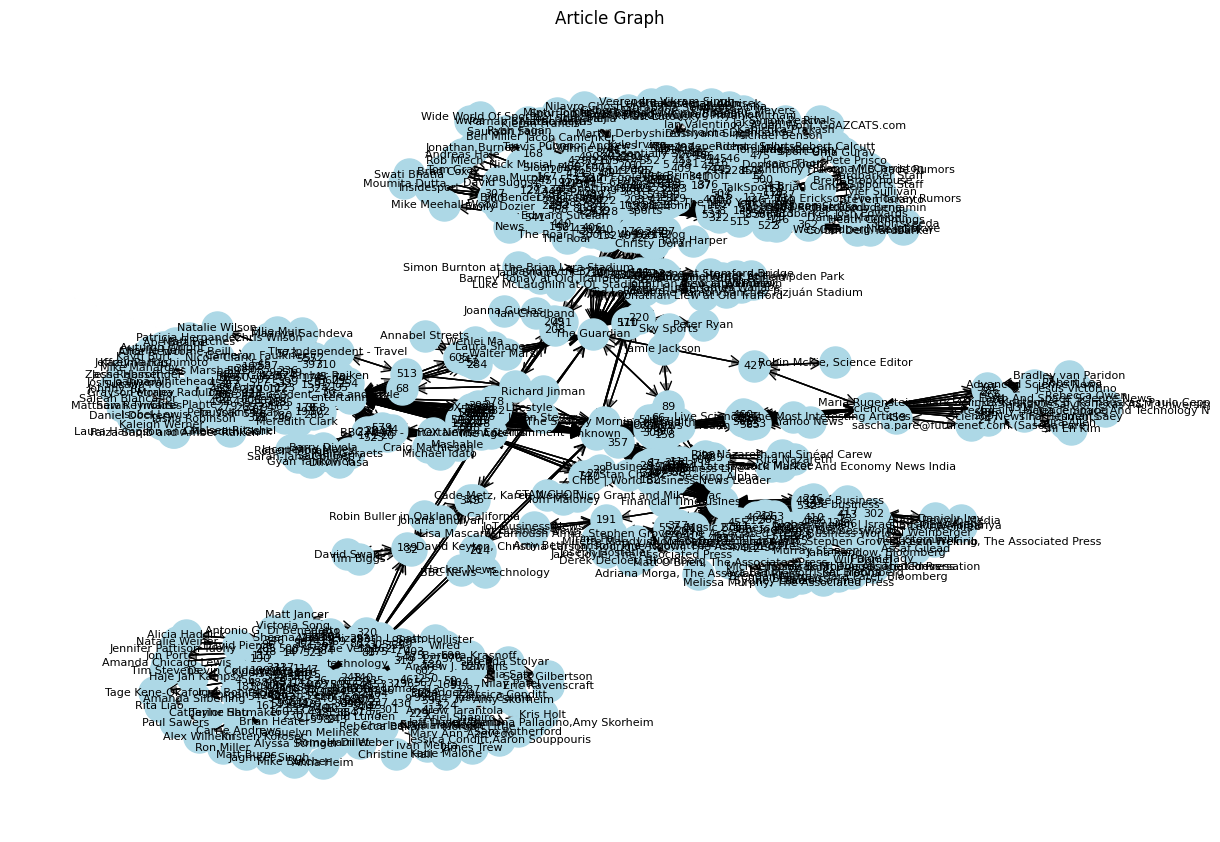

In [ ]:
## Optional: Draw the directed graph
#plt.figure(figsize=(12, 8))
#pos = nx.spring_layout(G, seed=42)  # Layout for better visualization
#nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, node_color="lightblue", edge_color="gray")
#nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20)
#plt.title("Article Graph")
#plt.show()

In [ ]:
# Find all nodes of the type "article"
articles = [n for n, d in G.nodes(data=True) if d.get("type") == "article"]
print("Articles:", articles)

Articles: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [17]:
# Function to get details of a specific node
def get_node_details(G, node_id):
    if node_id not in G:
        return f"Node '{node_id}' not found in the graph."
    
    # Get node attributes
    node_attributes = G.nodes[node_id]

    # Get all connected nodes (neighbors)
    neighbors = list(G.neighbors(node_id))

    # Get predecessors (incoming edges)
    predecessors = list(G.predecessors(node_id)) if isinstance(G, nx.DiGraph) else None

    # Get successors (outgoing edges)
    successors = list(G.successors(node_id)) if isinstance(G, nx.DiGraph) else None

    # Get edges related to the node
    edges = list(G.edges(node_id, data=True))

    # Print details
    print(f"📌 **Node ID:** {node_id}")
    print(f"🔹 **Attributes:** {node_attributes}")
    print(f"🔗 **Neighbors:** {neighbors}")
    if predecessors is not None:
        print(f"⬅️ **Predecessors (incoming edges):** {predecessors}")
    if successors is not None:
        print(f"➡️ **Successors (outgoing edges):** {successors}")
    print(f"🔄 **Edges:** {edges}")

In [ ]:
# Example usage
get_node_details(G, 'Christine Hall') 

📌 **Node ID:** Christine Hall
🔹 **Attributes:** {'type': 'author'}
🔗 **Neighbors:** [75]
⬅️ **Predecessors (incoming edges):** [75]
➡️ **Successors (outgoing edges):** [75]
🔄 **Edges:** [('Christine Hall', 75, {'relation': 'AUTHORED'})]


In [8]:
#text_splitter = RecursiveCharacterTextSplitter(
#    # Set a really small chunk size, just to show.
#    chunk_size=100,
#    chunk_overlap=20,
#    length_function=len,
#    is_separator_regex=False,
#)
#texts = text_splitter.create_documents([corpus])
#print(texts[0])
#print(texts[1])

In [9]:
## Crear un objeto Network
#net = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white")
#
## Convertir el grafo de networkx a PyVis
#net.from_nx(G)
#
## Opcional: configurar física, filtros, etc.
##net.show_buttons(filter_=['physics'])  # Muestra un menú para modificar parámetros de física
#
## Generar un archivo HTML y abrirlo en el navegador
#net.show("my_graph.html")

In [10]:
#from pyvis.network import Network
#import networkx as nx
#
## Supongamos que ya tienes G como nx.DiGraph() con nodos que tienen un atributo "type" o "title"
## Por ejemplo: G.add_node("article_1", title="Article about AI", type="article")
#
## Mapa de colores según el tipo
#color_map = {
#    "article": "lightgreen",
#    "author": "lightblue",
#    "source": "orange",
#    "category": "pink"
#}
#
## Crear el objeto Network
#net = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white")
#
## Agregar nodos con propiedades personalizadas
#for node, data in G.nodes(data=True):
#    node_type = data.get("type", "unknown")
#    # Usa 'title' como texto del label si existe; de lo contrario, usa el ID
#    label = data.get("title", str(node))
#    
#    net.add_node(
#        node,             # identificador interno
#        label=label,      # texto que se verá en el grafo
#        title=f"Type: {node_type}",  # tooltip al pasar el ratón
#        color=color_map.get(node_type, "gray")  # color según tipo
#    )
#
## Agregar aristas con propiedades personalizadas
#for source, target, edata in G.edges(data=True):
#    relation = edata.get("relation", "rel")
#    net.add_edge(
#        source,
#        target,
#        label=relation,    # etiqueta en la arista
#        title=relation     # tooltip al pasar el ratón
#    )
#
## Mostrar el menú de física, para ajustar repulsión y más
##net.show_buttons(filter_=['physics'])
#
## Generar el HTML y abrirlo en el navegador
#net.show("my_graph.html")
#